cuda:0


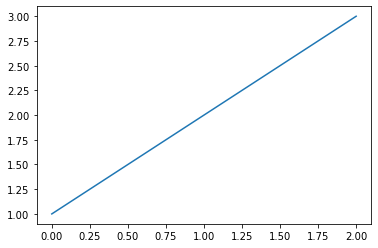

In [1]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env_new import RealExpEnv
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

succeed to connect
(128, 128)


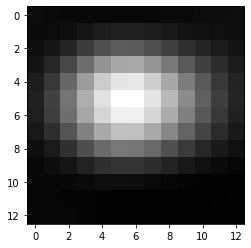

In [14]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (112,5), 13, 13
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [15]:
#test offset extration
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

16.082700729370117 -30.629756927490234


In [30]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 2
pixel = 128

im_size_nm = 12.015

offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([11, 18.5, -28.5, -19]) #[left, right, up, down]
template_max_y = 25
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 'atom_move_detector.pth', bottom=False, random_scan_rate = 0.8)


succeed to connect
Load cnn weight


In [31]:
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000

agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
#agent.critic.load_state_dict(torch.load('training_4/reward_2_critic_{}.pth'.format(2740)))
#agent.policy.load_state_dict(torch.load('training_4/reward_2_policy_{}.pth'.format(2740)))
#agent.alpha = torch.load('training_4/reward_2_alpha_{}.pth'.format(2740))
memory = HerReplayMemory(replay_size, env)

In [32]:
episode_memory = Episode_Memory()
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0'

In [33]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = max_len
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset()
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        print('old potential:',env.old_potential)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            
            
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                show_done(env.img_info, env.atom_absolute_nm, env.atom_start_absolute_nm, 
                          env.destination_absolute_nm, reward, env.template_nm, env.template_wh)
                break
            else:
                show_step(env.img_info, info['start_nm']+env.atom_absolute_nm, info['end_nm']+env.atom_absolute_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
                state=next_state
                
                
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                #c_k = memory.__len__()
                print('TRAINING!')
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha)
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))


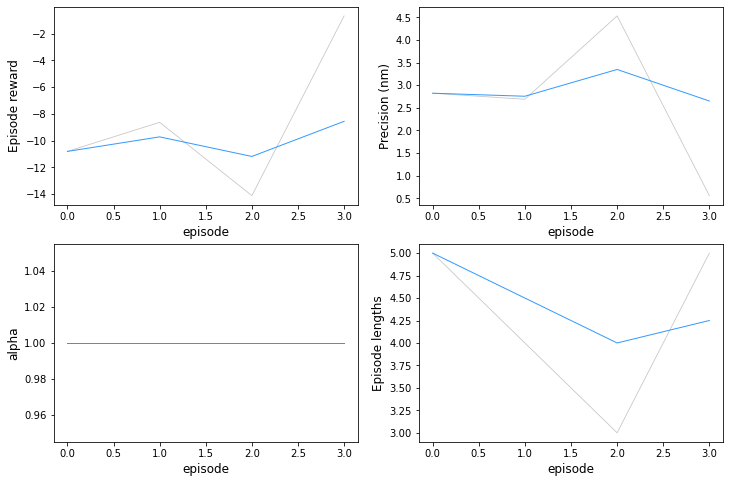

Episode: 4
goal_nm: 1.606033232794136


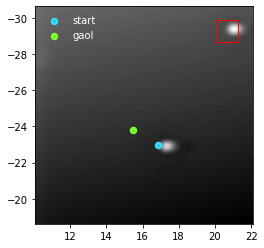

old potential: -5.7358329742647705
step: 0
70 78 86 95
Old prediction: True
Prediction: 0.5076089
cnn thinks there is atom movement
The scan will take 16.4 seconds
atom moves by: 1.5660911332328855
potential: -11.251199749391484
reward -6.515366775126713


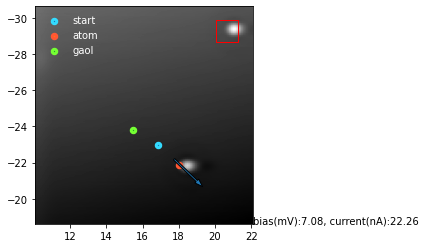

step: 1
86 93 77 98
Old prediction: False
Prediction: 0.15966955
CNN and old prediction both say no movement
potential: -11.251199749391484
reward -1.0


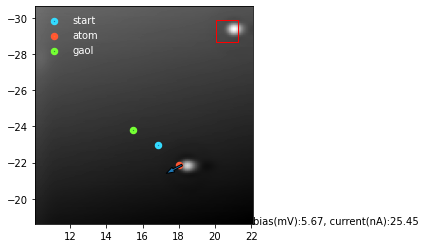

step: 2
81 93 90 91
Old prediction: False
Prediction: 0.15966955
Random scan
The scan will take 16.4 seconds
atom moves by: 1.5231745194347488
potential: -10.499130603194024
reward -0.24793085380253999


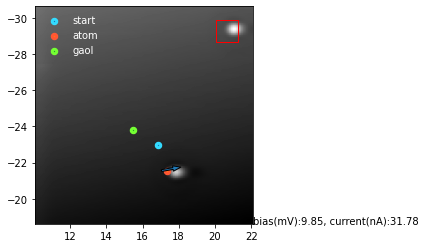

step: 3
74 93 66 112
Old prediction: False
Prediction: 0.15966955
Random scan
The scan will take 16.4 seconds
atom moves by: 1.5188783167335693
potential: -10.627229857826832
reward -1.128099254632808


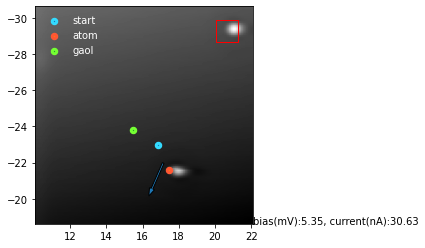

step: 4
80 92 59 117
The scan will take 16.4 seconds
atom moves by: 3.531764356539326
potential: -14.516281033700007
reward -4.889051175873176
Episode reward: -13.780448059435237


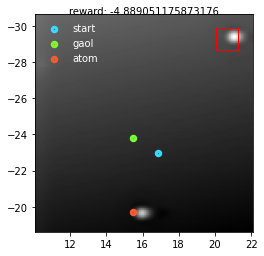

Episode: 5
pulling atom back to center
58 116 51 76
The scan will take 16.4 seconds
goal_nm: 1.1344501080068095


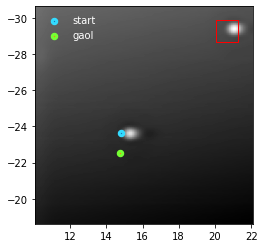

old potential: -4.051607528595747
step: 0
50 77 43 68
Old prediction: False
Prediction: 0.16823517
CNN and old prediction both say no movement
potential: -4.051607528595747
reward -1.0


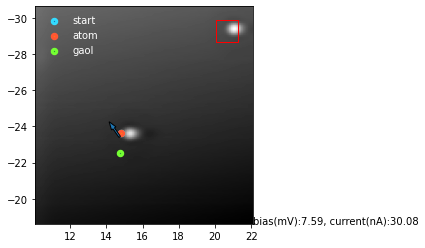

step: 1
50 70 33 94


In [ ]:
sac_train(max_steps=max_len, episode_start = 2,num_episodes = 1000)

In [9]:
env.atom_absolute_nm = None

In [35]:
env.current_jump = 3

In [7]:
np.delete(a,np.array([1,3]),axis=0)

array([[1, 3],
       [7, 7],
       [1, 1]])